In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, cross_val_predict, cross_val_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
# === Load data ===
train_df = pd.read_csv("D:/Downloads/train.csv")
test_df = pd.read_csv("D:/Downloads/test.csv")

In [5]:
# === 2. Preprocessing ===
target = 'class'
categorical = train_df.select_dtypes(include='object').columns.tolist()
categorical.remove(target)

In [6]:
# One-hot encode categorical features
X_raw = pd.get_dummies(train_df.drop(columns=[target]), columns=categorical)
y = LabelEncoder().fit_transform(train_df[target])

In [7]:
# Prepare test set for prediction (same transformation)
X_test_raw = pd.get_dummies(test_df.drop(columns=['ID'], errors='ignore'), columns=categorical)

In [8]:
# Align test set columns with train (in case of mismatch)
X_test_raw = X_test_raw.reindex(columns=X_raw.columns, fill_value=0)

In [9]:
# === 3. Scaling for MultinomialNB ===
scaler = MinMaxScaler()
X_nb = scaler.fit_transform(X_raw)
X_test_nb = scaler.transform(X_test_raw)

In [10]:
# === 4. Train models ===
rf = RandomForestClassifier(n_estimators=100, random_state=42)
svm = SVC(kernel='rbf', probability=True, random_state=42)
nb = MultinomialNB()

In [11]:
rf.fit(X_raw, y)

RandomForestClassifier(random_state=42)

In [12]:
svm.fit(X_raw, y)

SVC(probability=True, random_state=42)

In [13]:
nb.fit(X_nb, y)

MultinomialNB()

In [14]:
# === 5. Evaluation function ===
def evaluate_model(name, y_true, y_pred):
    print(f"\n=== {name} ===")
    acc = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {acc:.4f}")
    print("\nConfusion Matrix:")
    conf = confusion_matrix(y_true, y_pred)
    print(conf)
    sns.heatmap(conf, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix ({name})')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))


=== Random Forest (Train Set) ===
Accuracy: 1.0000

Confusion Matrix:
[[127   0]
 [  0  91]]


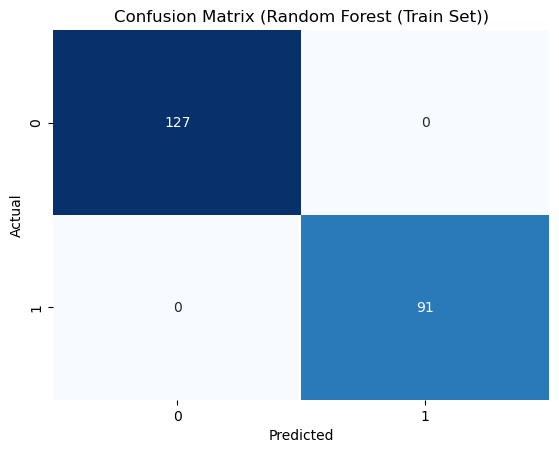


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       127
           1       1.00      1.00      1.00        91

    accuracy                           1.00       218
   macro avg       1.00      1.00      1.00       218
weighted avg       1.00      1.00      1.00       218



In [16]:
# === 6. Evaluate on Train Set ===
evaluate_model("Random Forest (Train Set)", y, rf.predict(X_raw))


=== SVM (Train Set) ===
Accuracy: 0.5826

Confusion Matrix:
[[127   0]
 [ 91   0]]


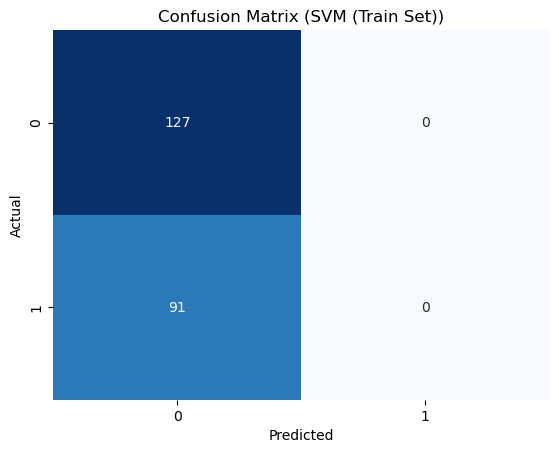


Classification Report:
              precision    recall  f1-score   support

           0       0.58      1.00      0.74       127
           1       0.00      0.00      0.00        91

    accuracy                           0.58       218
   macro avg       0.29      0.50      0.37       218
weighted avg       0.34      0.58      0.43       218



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
evaluate_model("SVM (Train Set)", y, svm.predict(X_raw))


=== Multinomial Naive Bayes (Train Set) ===
Accuracy: 0.9220

Confusion Matrix:
[[116  11]
 [  6  85]]


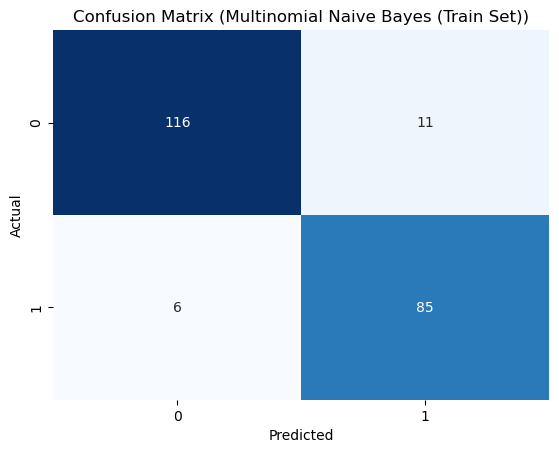


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.91      0.93       127
           1       0.89      0.93      0.91        91

    accuracy                           0.92       218
   macro avg       0.92      0.92      0.92       218
weighted avg       0.92      0.92      0.92       218



In [18]:
evaluate_model("Multinomial Naive Bayes (Train Set)", y, nb.predict(X_nb))

In [20]:
# === 7. Cross-validation ===
def cross_validate_model(name, model, X, y):
    print(f"\n=== Cross-validation: {name} ===")
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    y_pred_cv = cross_val_predict(model, X, y, cv=cv)
    acc = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    print(f"Mean Accuracy: {np.mean(acc):.4f}")
    print("\nConfusion Matrix:")
    conf = confusion_matrix(y, y_pred_cv)
    print(conf)
    sns.heatmap(conf, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Cross-Validated Confusion Matrix ({name})')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    print("\nClassification Report:")
    print(classification_report(y, y_pred_cv))
    print("Fold Accuracies:")
    for i, score in enumerate(acc, 1):
        print(f"Fold {i}: {score:.4f}")


=== Cross-validation: Random Forest ===
Mean Accuracy: 0.9588

Confusion Matrix:
[[122   5]
 [  4  87]]


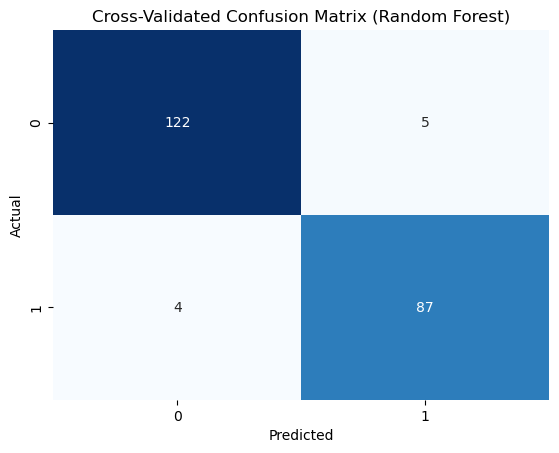


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       127
           1       0.95      0.96      0.95        91

    accuracy                           0.96       218
   macro avg       0.96      0.96      0.96       218
weighted avg       0.96      0.96      0.96       218

Fold Accuracies:
Fold 1: 0.9545
Fold 2: 0.9318
Fold 3: 0.9773
Fold 4: 0.9767
Fold 5: 0.9535


In [21]:
# Perform cross-validation
cross_validate_model("Random Forest", rf, X_raw, y)


=== Cross-validation: SVM ===
Mean Accuracy: 0.5826

Confusion Matrix:
[[127   0]
 [ 91   0]]


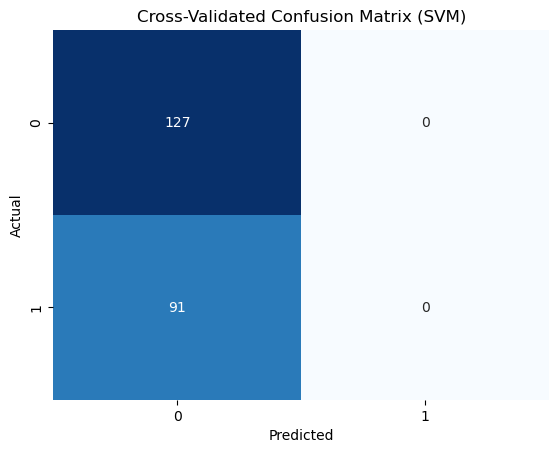


Classification Report:
              precision    recall  f1-score   support

           0       0.58      1.00      0.74       127
           1       0.00      0.00      0.00        91

    accuracy                           0.58       218
   macro avg       0.29      0.50      0.37       218
weighted avg       0.34      0.58      0.43       218

Fold Accuracies:
Fold 1: 0.5909
Fold 2: 0.5909
Fold 3: 0.5682
Fold 4: 0.5814
Fold 5: 0.5814


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
cross_validate_model("SVM", svm, X_raw, y)


=== Cross-validation: Multinomial Naive Bayes ===
Mean Accuracy: 0.9174

Confusion Matrix:
[[114  13]
 [  5  86]]


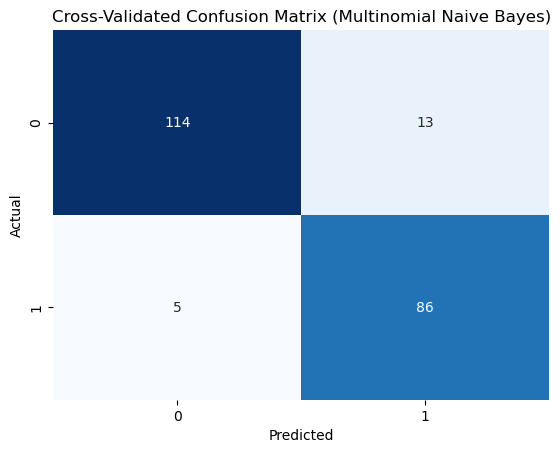


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.90      0.93       127
           1       0.87      0.95      0.91        91

    accuracy                           0.92       218
   macro avg       0.91      0.92      0.92       218
weighted avg       0.92      0.92      0.92       218

Fold Accuracies:
Fold 1: 0.9318
Fold 2: 0.8864
Fold 3: 0.9318
Fold 4: 0.9535
Fold 5: 0.8837


In [23]:
cross_validate_model("Multinomial Naive Bayes", nb, X_nb, y)